Lets import the useful libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import pyplot as plt
from matplotlib import style

from scipy.stats import randint as scp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, 
                                     RandomizedSearchCV)
from sklearn.metrics import (auc, 
                             confusion_matrix, 
                             f1_score, 
                             roc_auc_score, 
                             roc_curve)

from tqdm import tqdm

In [3]:
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xgboost as xgb

In [4]:
style.use(style='seaborn-deep')

Reading data.

In [5]:
if os.path.isfile(path='data/after_eda/train_pos_after_eda.csv'):
    train_graph = nx.read_edgelist(path='data/after_eda/train_pos_after_eda.csv',
                                   delimiter=',',
                                   create_using=nx.DiGraph(),
                                   nodetype=int)
    print(nx.info(train_graph))
else:
    print("Please run the FB-Friend-Recommendation-EDA.ipynb file.")

DiGraph with 1780722 nodes and 7550015 edges


Reading the h5 files.

In [6]:
df_final_train = pd.read_hdf(path_or_buf='data/fea_sample/storage_sample_stage4.h5',
                             key='train_df',
                             mode='r')
df_final_test = pd.read_hdf(path_or_buf='data/fea_sample/storage_sample_stage4.h5',
                            key='test_df',
                            mode='r')

In [7]:
print(df_final_train.columns)

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')


Preferential attachment.

One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

Link: http://be.amazd.com/link-prediction/

In [8]:
class PreferentialAttachment(object):
    """
    This class provides the logic to compute the preferential attachment
    for followers and followees in a social network.
    """
    
    def __init__(self, df, s, d):
        self.df = df
        self.s = s
        self.d = d
        self.s_list = self.df[self.s].to_list()
        self.d_list = self.df[self.d].to_list()
        self.sd_list = zip(self.s_list, self.d_list)
    
    def get_pa_followees(self, nodes):
        """
        This method gets the preferential attachment of followees for given nodes.
        """
        u, v = nodes
        try:
            u_s = set(train_graph.successors(n=u))
            v_s = set(train_graph.successors(n=v))
            pa_followees = len(u_s) * len(v_s)
        except:
            pa_followees = 0
        return pa_followees
    
    def get_pa_followers(self, nodes):
        """
        This method gets the preferential attachment of followers for given nodes.
        """
        u, v = nodes
        try:
            u_p = set(train_graph.predecessors(n=u))
            v_p = set(train_graph.predecessors(n=v))
            pa_followers = len(u_p) * len(v_p)
        except:
            pa_followers = 0
        return pa_followers
    
    def compute_pa_followees_followers(self):
        """
        This method computes the preferential attachment.
        """
        pa_followees_list = list()
        pa_followers_list = list()
        for nodes in self.sd_list:
            pa_followees_list.append(self.get_pa_followees(nodes=nodes))
            pa_followers_list.append(self.get_pa_followers(nodes=nodes))
        return pa_followees_list, pa_followers_list

In [9]:
pa_train_obj = PreferentialAttachment(df=df_final_train, s='source_node', d='destination_node')
pa_followees_train, pa_followers_train = pa_train_obj.compute_pa_followees_followers()

In [10]:
pa_test_obj = PreferentialAttachment(df=df_final_test, s='source_node', d='destination_node')
pa_followees_test, pa_followers_test = pa_test_obj.compute_pa_followees_followers()

SVD dot.

In [11]:
class SVDDot(object):
    """
    This class computes SVD dot feature.
    """
    
    def __init__(self, df):
        self.df = df
    
    def get_columns(self, pattern):
        """
        Gets the column names based on pattern.
        """
        return sorted([col 
                       for col in self.df.columns 
                       if col.startswith(pattern)])
    
    def get_svd_matrices(self):
        """
        This method gets the feature matrices for source and destination.
        """
        s_u_cols = self.get_columns(pattern='svd_u_s')
        d_u_cols = self.get_columns(pattern='svd_u_d')
        s_v_cols = self.get_columns(pattern='svd_v_s')
        d_v_cols = self.get_columns(pattern='svd_v_d')
        s_u_matrix = self.df[s_u_cols].values
        d_u_matrix = self.df[d_u_cols].values
        s_v_matrix = self.df[s_v_cols].values
        d_v_matrix = self.df[d_v_cols].values
        return s_u_matrix, d_u_matrix, s_v_matrix, d_v_matrix
    
    def compute_svd_dot(self, s_matrix, d_matrix):
        """
        This method computes the svd dot.
        """
        s_shape = s_matrix.shape
        d_shape = d_matrix.shape
        bound = s_shape[0] if s_shape == d_shape else 0
        if bound == 0:
            return None
        else:
            svd_dot_feature = list()
            for i in range(bound):
                value = s_matrix[i] * d_matrix[i]
                svd_dot_feature.append(value.sum())
            return svd_dot_feature

In [12]:
svd_dot_train_obj = SVDDot(df=df_final_train)
(s_u_matrix_train, 
 d_u_matrix_train, 
 s_v_matrix_train, 
 d_v_matrix_train) = svd_dot_train_obj.get_svd_matrices()
svd_u_train = svd_dot_train_obj.compute_svd_dot(s_matrix=s_u_matrix_train, d_matrix=d_u_matrix_train)
svd_v_train = svd_dot_train_obj.compute_svd_dot(s_matrix=s_v_matrix_train, d_matrix=d_v_matrix_train)

In [13]:
svd_dot_test_obj = SVDDot(df=df_final_test)
(s_u_matrix_test, 
 d_u_matrix_test, 
 s_v_matrix_test, 
 d_v_matrix_test) = svd_dot_test_obj.get_svd_matrices()
svd_u_test = svd_dot_test_obj.compute_svd_dot(s_matrix=s_u_matrix_test, d_matrix=d_u_matrix_test)
svd_v_test = svd_dot_test_obj.compute_svd_dot(s_matrix=s_v_matrix_test, d_matrix=d_v_matrix_test)

In [14]:
df_final_train['pa_followees'] = pa_followees_train
df_final_train['pa_followers'] = pa_followers_train
df_final_train['svd_u_sd'] = svd_u_train
df_final_train['svd_v_sd'] = svd_v_train

In [15]:
df_final_test['pa_followees'] = pa_followees_test
df_final_test['pa_followers'] = pa_followers_test
df_final_test['svd_u_sd'] = svd_u_test
df_final_test['svd_v_sd'] = svd_v_test

In [16]:
display(df_final_train.head())
display(df_final_train.tail())

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pa_followees,pa_followers,svd_u_sd,svd_v_sd
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,120,66,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8662,1598,3.192812e-03,9.068719e-04
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,902,980,1.787503e-35,2.467873e-36
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,35,22,4.710376e-20,3.159386e-18
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,33,5,7.773952e-14,0.000000e+00


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pa_followees,pa_followers,svd_u_sd,svd_v_sd
99997,139353,893843,0,0,0.0,0.0,0.0,7,1,10,...,-3.303718e-12,1.538318e-13,1.296745e-06,2.990887e-13,1.589668e-12,7.338551e-14,10,0,-8.826350e-26,0.000000e+00
99998,910842,704068,0,0,0.0,0.0,0.0,0,4,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4,0,1.428815e-31,0.000000e+00
99999,794228,1172755,0,0,0.0,0.0,0.0,0,5,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,0,4.158491e-22,0.000000e+00
100000,949992,1854931,0,0,0.0,0.0,0.0,1,2,0,...,-1.142753e-17,5.200344e-17,3.858875e-15,2.173437e-17,2.241477e-16,3.528355e-20,0,1,4.300967e-30,6.252591e-26
100001,1642037,1090977,0,0,0.0,0.0,0.0,1,14,0,...,-1.657134e-14,2.085059e-14,2.107704e-07,2.652994e-12,2.004727e-14,2.805020e-14,0,16,1.026399e-26,1.639391e-15


In [17]:
display(df_final_test.head())
display(df_final_test.tail())

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pa_followees,pa_followers,svd_u_sd,svd_v_sd
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,...,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,54,84,8.425267e-20,2.074808e-17
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,...,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,19,34,1.352160e-17,1.188376e-17
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,...,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,144,150,3.671980e-13,3.904885e-12
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,...,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,340,407,1.634044e-10,9.819784e-11
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,...,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,405,324,1.246700e-11,1.300892e-11


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pa_followees,pa_followers,svd_u_sd,svd_v_sd
49997,1167544,310247,0,0,0.0,0.0,0.0,1,2,1,...,-4.174048e-13,7.974605e-13,2.869729e-13,4.138512e-14,1.485636e-13,4.049533e-15,2,1,1.819244e-22,3.745093e-26
49998,656027,1761965,0,0,0.0,0.0,0.0,4,1,3,...,-5.192095e-17,1.629514e-17,5.679433e-17,1.319512e-16,3.830055e-17,7.507784e-21,3,4,5.119593e-31,3.687099e-31
49999,1304926,958643,0,0,0.0,0.0,0.0,0,0,2,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0.000000e+00,0.000000e+00
50000,773347,1488855,0,0,0.0,0.0,0.0,1,0,0,...,-8.872392e-14,2.460486e-16,1.541675e-15,6.293880e-16,1.573532e-17,2.077936e-19,0,0,0.000000e+00,0.000000e+00
50001,1253866,281538,0,0,0.0,0.0,0.0,18,2,15,...,-5.283956e-16,8.119026e-16,9.464475e-14,6.355982e-14,2.319323e-14,1.322574e-14,30,0,3.854395e-29,0.000000e+00


Features and Target.

In [18]:
y_train = df_final_train['indicator_link'].values
y_test = df_final_test['indicator_link'].values

In [19]:
df_final_train.drop(labels=['source_node', 'destination_node','indicator_link'], axis=1, inplace=True)
df_final_test.drop(labels=['source_node', 'destination_node','indicator_link'], axis=1, inplace=True)

Hyperparameter tuning.

In [20]:
def plotting(x, xlabel, ylabel, title):
    """
    This method plots.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(x, train_scores, label='Train Score')
    plt.plot(x, test_scores, label='Test Score')
    plt.xlabel(xlabel=xlabel)
    plt.ylabel(ylabel=ylabel)
    plt.title(label=title)
    plt.grid()
    plt.legend()
    plt.show()

In [21]:
estimators = [10, 50, 100, 250, 450]
train_scores = []
test_scores = []

for estim in estimators:
    clf = xgb.XGBClassifier(n_estimators=estim, max_depth=5)
    clf.fit(X=df_final_train, y=y_train)
    
    y_train_pred = clf.predict(X=df_final_train)
    train_sc = f1_score(y_true=y_train, y_pred=y_train_pred)
    train_scores.append(train_sc)
    
    y_test_pred = clf.predict(X=df_final_test)
    test_sc = f1_score(y_true=y_test, y_pred=y_test_pred)
    test_scores.append(test_sc)
    
    print("Estimators = {}, Train Score: {}, Test Score: {}".format(estim, train_sc, test_sc))

Estimators = 10, Train Score: 0.9644729769474953, Test Score: 0.9271052410196012
Estimators = 50, Train Score: 0.9809717906291618, Test Score: 0.9280332774464654
Estimators = 100, Train Score: 0.9892404046892564, Test Score: 0.9227652678266802
Estimators = 250, Train Score: 0.9994903618430915, Test Score: 0.9095815881514746
Estimators = 450, Train Score: 1.0, Test Score: 0.9005354111348104


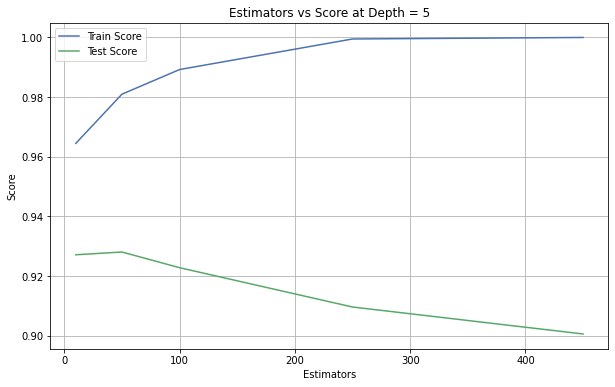

In [22]:
plotting(x=estimators, xlabel='Estimators', ylabel='Score', title='Estimators vs Score at Depth = 5')

In [23]:
depths = [3, 9, 11, 15, 20, 35, 50, 70, 130]
train_scores = []
test_scores = []

for dep in depths:
    clf = xgb.XGBClassifier(n_estimators=115, max_depth=dep)
    clf.fit(X=df_final_train, y=y_train)
    
    y_train_pred = clf.predict(X=df_final_train)
    train_sc = f1_score(y_true=y_train, y_pred=y_train_pred)
    train_scores.append(train_sc)
    
    y_test_pred = clf.predict(X=df_final_test)
    test_sc = f1_score(y_true=y_test, y_pred=y_test_pred)
    test_scores.append(test_sc)
    
    print("Depth = {}, Train Score: {}, Test Score: {}".format(dep, train_sc, test_sc))

Depth = 3, Train Score: 0.9805562839105266, Test Score: 0.8994250370241311
Depth = 9, Train Score: 1.0, Test Score: 0.9258039149008522
Depth = 11, Train Score: 1.0, Test Score: 0.9260533469249065
Depth = 15, Train Score: 1.0, Test Score: 0.9268768832491618
Depth = 20, Train Score: 1.0, Test Score: 0.928550252001186
Depth = 35, Train Score: 1.0, Test Score: 0.9295178427803413
Depth = 50, Train Score: 1.0, Test Score: 0.9294259639612933
Depth = 70, Train Score: 1.0, Test Score: 0.9294259639612933
Depth = 130, Train Score: 1.0, Test Score: 0.9294259639612933


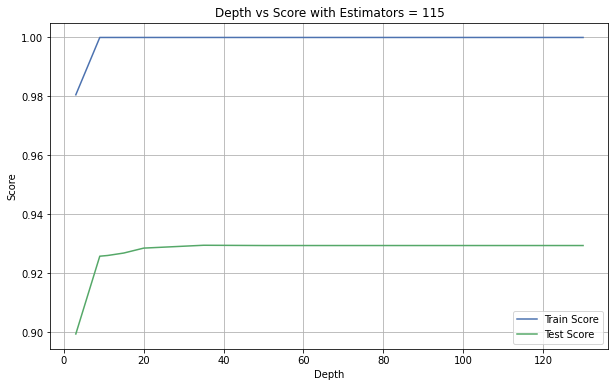

In [24]:
plotting(x=depths, xlabel='Depth', ylabel='Score', title='Depth vs Score with Estimators = 115')

In [25]:
param_dist = {"n_estimators": scp_randint(40, 60), "max_depth": scp_randint(5, 15)}

In [26]:
clf = xgb.XGBClassifier(random_state=25)

rf_random = RandomizedSearchCV(estimator=clf, 
                               param_distributions=param_dist, 
                               n_iter=5, 
                               cv=10, 
                               scoring='f1', 
                               random_state=25, 
                               n_jobs=-1)
rf_random.fit(X=df_final_train, y=y_train)
print("Mean test scores: {}".format(rf_random.cv_results_['mean_test_score']))

Mean test scores: [0.98096672 0.9808361  0.97939944 0.97996164 0.97879125]


In [27]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=55, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=25,
              reg_alpha=0, reg_lambda=1, ...)


Model.

In [30]:
clf_main = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                             early_stopping_rounds=None, enable_categorical=False,
                             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                             importance_type=None, interaction_constraints='',
                             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
                             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
                             missing=np.nan, monotone_constraints='()', n_estimators=55, n_jobs=0,
                             num_parallel_tree=1, predictor='auto', random_state=25)
clf_main.fit(X=df_final_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=55, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=25,
              reg_alpha=0, reg_lambda=1, ...)

In [32]:
y_train_pred = clf_main.predict(X=df_final_train)
y_test_pred = clf_main.predict(X=df_final_test)

In [34]:
labels = clf_main.classes_
print(labels)

[0 1]


Confusion matrix.

In [35]:
def plot_confusion_matrix(y_true, y_pred, labels=labels):
    """
    This plots the confusion matrices.
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred) # confusion
    
    pmat = cmat / cmat.sum(axis=0) # axis = 0: consider all the rows in each column
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T # axis = 1: consider all the columns in each row
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    cmap = sns.light_palette("blue")

    plt.figure(figsize=(20, 4))
    
    # consufion plot
    plt.subplot(1, 3, 1)
    sns.heatmap(data=cmat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # precision plot
    plt.subplot(1, 3, 2)
    sns.heatmap(data=pmat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    # recall plot
    plt.subplot(1, 3, 3)
    sns.heatmap(data=rmat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion matrix
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


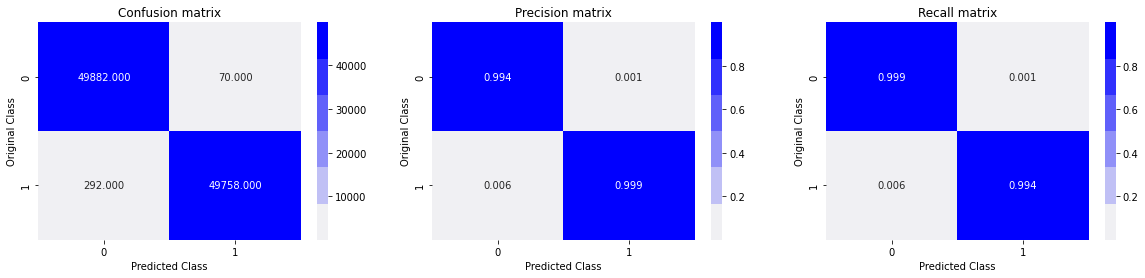

Test confusion matrix
Column sum of precision matrix: [1. 1.]
Row sum of recall matrix:       [1. 1.]


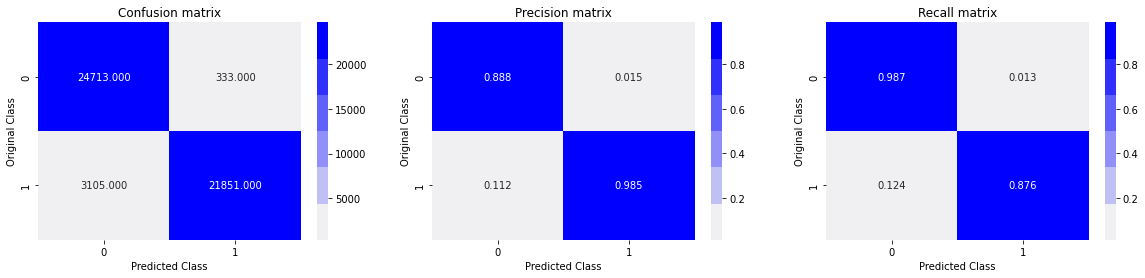

In [36]:
print('Train confusion matrix')
plot_confusion_matrix(y_true=y_train, y_pred=y_train_pred)
print('Test confusion matrix')
plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred)

ROC & AUC.

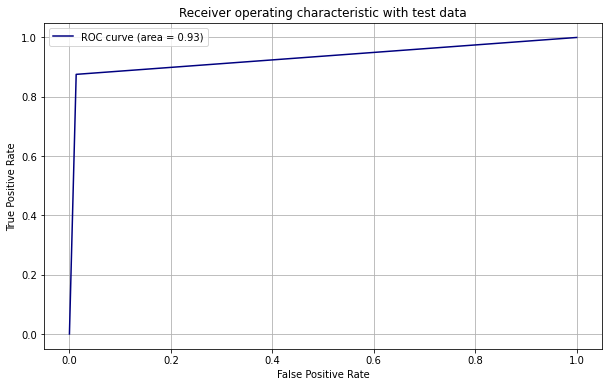

In [37]:
fpr, tpr, ths = roc_curve(y_true=y_test, y_score=y_test_pred)
auc_sc = auc(x=fpr, y=tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel(xlabel='False Positive Rate')
plt.ylabel(ylabel='True Positive Rate')
plt.title(label='Receiver operating characteristic with test data')
plt.grid()
plt.legend()
plt.show()

Feature importance.

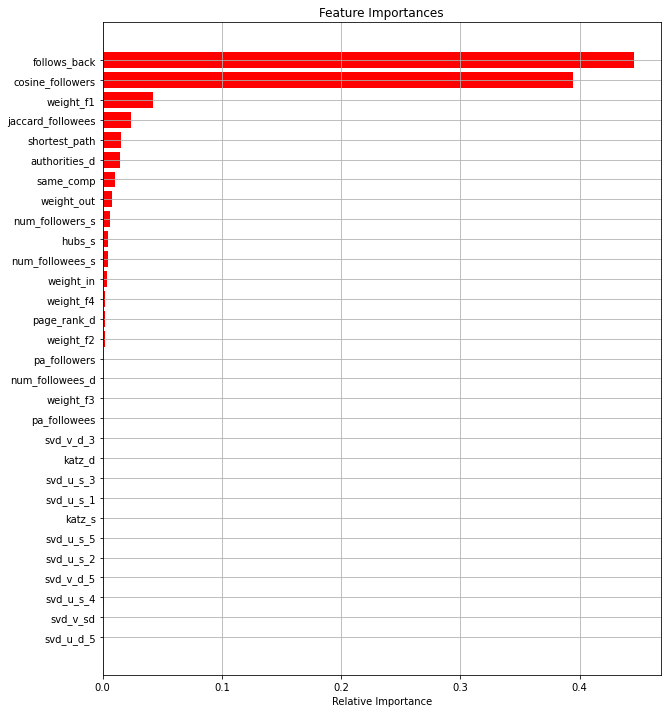

In [39]:
features = df_final_train.columns
importances = clf_main.feature_importances_
indices = (np.argsort(importances))[-30:]

plt.figure(figsize=(10,12))
plt.title(label='Feature Importances')
plt.barh(y=range(len(indices)), width=importances[indices], color='r', align='center')
plt.yticks(ticks=range(len(indices)), labels=[features[i] for i in indices])
plt.xlabel(xlabel='Relative Importance')
plt.grid()
plt.show()

We can see `pa_followers`, `pa_followees` and `svd_v_sd` do contribute to performance of the model and falls under top 30 features.

End of the file.